In [1]:
import CodaPCA
import numpy as np
from runpca import read_csv
import os
import sklearn
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
#change module for newer sklearn versions
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection  import KFold
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\Sean\Anaconda3\envs\honours\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [2]:
#read in the data. Given an array of which files are regression, classification or unlabelled
data_path = os.getcwd() + "\\Aitchinson"

regression_list = [3,4,5,18,21,34,39]
classification_list = [7,8,9,11,12,16,17,19,23,24,25,26,28,29,33,37]
unlabelled_list=[1,2,6,10,13,14,15,20,22,27,30,31,32,35,36,38,40]

r_files = []
c_files = []
u_files = []


for file in os.listdir(data_path):
    for i in regression_list:
        if os.path.isfile(os.path.join(data_path,file)) and 'Data ' + str(i) + '.' in file:
            r_files.append("Aitchinson/" + file)
    for i in classification_list:
        if os.path.isfile(os.path.join(data_path,file)) and 'Data ' + str(i) + '.' in file:
            c_files.append("Aitchinson/" + file)
    for i in unlabelled_list:
        if os.path.isfile(os.path.join(data_path,file)) and 'Data ' + str(i) + '.' in file:
            u_files.append("Aitchinson/" + file)

In [3]:

#need to specify where the the targets and features are in the dataset, and whether there are non compositional features

def PCA_Regression(data, co_feature_indices, target_index, 
                   other_feature_indices = [], alg=CodaPCA.Alg.CODAPCA, verbose=False):
    
    #can loop through/optimise this in another way?
    
    headers = data[1]
    features = data[0][:,co_feature_indices]
    targets = data[0][:,target_index]
    
    #normalise the compositional features. TODO anything extra to deal with non compositional features?
    features = np.array([feat/sum(feat) for feat in features])

    #can be empty
    extra_features = data[0][:,other_feature_indices]
    
    #TODO double check this
    features = np.hstack([features, extra_features])
    
    #compute the CoDA-PCA projection 
    #TODO add component number as a hyperparameter to optimise 
    n_components=len(co_feature_indices)-2

    pca = CodaPCA.CodaPCA(n_components,lrate=1e-3,nn_shape=[100,100], alg=alg)
    #TODO: check why this is numerically unstable
    #pca = CodaPCA.NonParametricCodaPCA(n_components)

    pca.fit(features)
    
    Y_coda = pca.project(features)

    pca_clr = CodaPCA.CLRPCA(n_components)
    pca_clr.fit(features)
    
    Y_clr = pca_clr.project(features)

    lm = Ridge()
    #exp the projection to get out of clr space
    coda_score = enhanced_cross_val(lm,np.exp(Y_coda), targets)
    clr_score = enhanced_cross_val(lm,np.exp(Y_clr), targets) 
    naive_score = enhanced_cross_val(lm, features, targets)


    if verbose:
        print("CoDA-PCA:")
        print(coda_score)
        print("CLR-PCA:")
        print(clr_score)
        print ("Naive regression:")
        print (naive_score)
    

    return coda_score,clr_score,naive_score

#training methodology as described in:
#https://papers.nips.cc/paper/3215-learning-with-transformation-invariant-kernels.pdf
def enhanced_cross_val(model, features, targets):
    assert len(features) == len(targets), "Mismatch in length of features and targets"
    
    #define the number of splits and folds uised in the parameter selection
    #stick to smaller splits since we have small datasets
    splits = 4
    param_splits = 3
    
    #split data 
    kf = KFold(splits)
    kfold_scores = []
    for train, test in kf.split(features):        
        Y_train = targets[train]
        X_train = features[train]
        
       
        Y_test = targets[test]
        X_test = features[test]
        
        #inner loop for parameter selection (regularisation term in Ridge Regression):
        param_grid = [0.01,0.05,0.1,0.5,1.0,2.0,5.0,10.0,20.0,100.0]
        for a in param_grid:
            max_score = -np.inf
            lm = Ridge(a)
   
            curr_score = np.mean(cross_val_score(lm, X_train, Y_train,cv=param_splits))
            if curr_score > max_score:
                max_score = curr_score
                best_param = a
        
        #compute test score based on best parameter
        lm = Ridge(best_param)
        lm.fit(X_train, Y_train)
        kfold_scores.append(lm.score(X_test, Y_test))
        
    return kfold_scores



#can automate this if we had assume a certain structure for the indices of features and targets, or an array per dataset 

score_dict = {}

data_18_scores = PCA_Regression(read_csv(r_files[0], normalize=False), co_feature_indices=[0,1,2,3], target_index=4)
#other "target" also at 5
score_dict['18'] = data_18_scores

data_21_scores = PCA_Regression(read_csv(r_files[1], normalize=False), co_feature_indices=[0,1,2,3], target_index=4) 
score_dict['21'] = data_21_scores

data_3_scores = PCA_Regression(read_csv(r_files[2], normalize=False), co_feature_indices=[0,1,2,3,4], target_index=5) 
score_dict['3'] = data_3_scores

data_34_scores = PCA_Regression(read_csv(r_files[3], normalize=False), co_feature_indices=[0,1,2,3], target_index=4)
score_dict['34'] = data_34_scores

data_39_scores = PCA_Regression(read_csv(r_files[4], normalize=False), co_feature_indices=[0,1,2], target_index=3)
score_dict['39'] = data_39_scores

data_4_scores = PCA_Regression(read_csv(r_files[5], normalize=False), co_feature_indices=[0,1,2,3,4], target_index=5)
score_dict['4'] = data_4_scores

data_5_scores =PCA_Regression(read_csv(r_files[6], normalize=False), co_feature_indices=[0,1,2], target_index=3)
score_dict['5'] = data_5_scores


loading Aitchinson/Data 18. Compositions and total pebble counts of 92 glacial tills.csv...
92 samples 5 features
sparsity: 10.434782608695652%
[epoch     0] L= -2.2010
loading Aitchinson/Data 21. Permeabilities of bayesite for 21 mixtures of fibres and bonding pressures..csv...
21 samples 6 features
sparsity: 0.0%
[epoch     0] L=  5.2960
loading Aitchinson/Data 3. Compositions and depths of 25 specimens of boxite (Percentages by weight).csv...
25 samples 6 features
sparsity: 0.0%
[epoch     0] L=  4.1681
loading Aitchinson/Data 34. Foraminiferal compositions at 30 different depths.csv...
30 samples 5 features
sparsity: 3.3333333333333335%
[epoch     0] L=  2.0909
loading Aitchinson/Data 39. Microhardness of 18 glass specimens and their (Ge, Sb, Se) compositions.csv...
18 samples 4 features
sparsity: 0.0%
[epoch     0] L=  2.1665
loading Aitchinson/Data 4. Compositions, depths and porosities of 25 specimens of coxite (Percentages by weight).csv...
25 samples 7 features
sparsity: 0.0%


In [4]:
#note: plotly code works fine, but gives a jupyter warning when saving with a rendered table

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


init_notebook_mode(connected=True)


table_rows = []
for key in score_dict.keys():
    mean_scores = list(map(np.mean, score_dict[key]))
    table_rows.append([key,*mean_scores])
    
results = [go.Table(
    header=dict(values=["Dataset","CoDA-PCA", "CLR-PCA", "Naive Regression"]),
    cells=dict(values=np.array(table_rows).T))]

iplot(results, filename = 'basic_table')    
    


In [5]:
def PCA_Classification(data, co_feature_indices, target_index, 
                   other_feature_indices = [], alg=CodaPCA.Alg.CODAPCA, verbose=False):
       #can loop through/optimise this in another way?
    
    headers = data[1]
    features = data[0][:,co_feature_indices]
    targets = data[0][:,target_index]
    
    #normalise the compositional features. TODO anything extra to deal with non compositional features?
    features = np.array([feat/sum(feat) for feat in features])

    #can be empty
    extra_features = data[0][:,other_feature_indices]
    
    #TODO double check this
    features = np.hstack([features, extra_features])
    
    #compute the CoDA-PCA projection 
    #TODO add component number as a hyperparameter to optimise 
    n_components=len(co_feature_indices)-2

    pca = CodaPCA.CodaPCA(n_components,lrate=1e-3,nn_shape=[100,100], alg=alg)
    #TODO: check why this is numerically unstable
    #pca = CodaPCA.NonParametricCodaPCA(n_components)

    pca.fit(features)
    
    Y_coda = pca.project(features)

    pca_clr = CodaPCA.CLRPCA(n_components)
    pca_clr.fit(features)
    
    Y_clr = pca_clr.project(features)

    classifier = LogisticRegression()
    #exp the projection to get out of clr space
    coda_score = enhanced_cross_val(classifier,np.exp(Y_coda), targets)
    clr_score = enhanced_cross_val(classifier,np.exp(Y_clr), targets) 
    naive_score = enhanced_cross_val(classifier, features, targets)


    if verbose:
        print("CoDA-PCA:")
        print(coda_score)
        print("CLR-PCA:")
        print(clr_score)
        print ("Naive Classification:")
        print (naive_score)
    

    return coda_score,clr_score,naive_score

    
    
    

In [6]:
data_9 = pd.read_csv(c_files[-1])
adult_inds = np.where(data_9['Adult/Child'] == 'A')
child_inds = np.where(data_9['Adult/Child'] == 'C')

adult = data_9.to_numpy()[adult_inds]
child = data_9.to_numpy()[child_inds]
features = data_9[data_9.columns[2:]].to_numpy()


features = np.array([feat/sum(feat) for feat in features])



# pca_clr = CodaPCA.CLRPCA(2)
# pca_clr.fit(features)
# test = pca_clr.transform(features)

pca = CodaPCA.CodaPCA(2,lrate=1e-3,nn_shape=[100,100], alg=CodaPCA.Alg.CODAPCA)
pca.fit(features)
test = pca.transform(features)

plt.scatter(x = test[adult_inds][:,0], y = test[adult_inds][:,1], c ="red")
plt.scatter(x = test[child_inds][:,0], y = test[child_inds][:,1], c ="orange")


plt.show()




[epoch     0] L=  1.3422


C:\Users\Sean\Anaconda3\envs\honours\lib\site-packages\matplotlib\figure.py:445: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



[epoch     0] L=-1501.8110


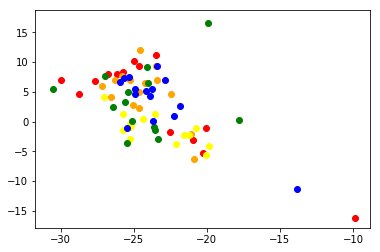

array([-27.632809, -20.915133, -22.515554, -23.478842, -28.769754,
       -29.980255,  -9.872391, -25.735434, -26.133247, -24.968039,
       -20.283714, -20.046415, -24.603176, -26.763027], dtype=float32)

In [7]:
%matplotlib inline
import pandas as pd
bee_data = pd.read_csv("beeMicrobiome.csv")
bee_classes = bee_data[bee_data.columns[3:]]


#group into classes
apiary_a = np.where(bee_classes['Apiary'] == 'A')
apiary_b = np.where(bee_classes['Apiary'] == 'B')
apiary_c = np.where(bee_classes['Apiary'] == 'C')
apiary_d = np.where(bee_classes['Apiary'] == 'D')
apiary_e = np.where(bee_classes['Apiary'] == 'E')

bee_features = bee_classes.to_numpy()[:,1:]


bee_features = np.array([feat/sum(feat) for feat in bee_features])


pca = CodaPCA.CodaPCA(2,lrate=1e-3,nn_shape=[100,100], alg=CodaPCA.Alg.CODAPCA)
pca.fit(bee_features)
test = pca.transform(bee_features)

plt.scatter(x = test[apiary_a][:,0], y = test[apiary_a][:,1], c ="red")
plt.scatter(x = test[apiary_b][:,0], y = test[apiary_b][:,1], c ="orange")
plt.scatter(x = test[apiary_c][:,0], y = test[apiary_c][:,1], c ="yellow")
plt.scatter(x = test[apiary_d][:,0], y = test[apiary_d][:,1], c ="green")
plt.scatter(x = test[apiary_e][:,0], y = test[apiary_e][:,1], c ="blue")

plt.show()

test[apiary_a][:,0]

[epoch     0] L=-2940.6289


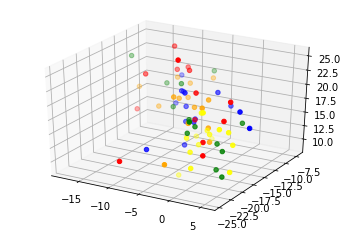

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



pca = CodaPCA.CodaPCA(3,lrate=1e-3,nn_shape=[100,100], alg=CodaPCA.Alg.CODAPCA)
pca.fit(bee_features)
test = pca.transform(bee_features)

ax.scatter(xs = test[apiary_a][:,0], ys = test[apiary_a][:,1], zs = test[apiary_a][:,2],c ="red")
ax.scatter(xs = test[apiary_b][:,0], ys = test[apiary_b][:,1],zs = test[apiary_b][:,2], c ="orange")
ax.scatter(xs = test[apiary_c][:,0], ys = test[apiary_c][:,1],zs = test[apiary_c][:,2], c ="yellow")
ax.scatter(xs = test[apiary_d][:,0], ys = test[apiary_d][:,1],zs = test[apiary_d][:,2], c ="green")
ax.scatter(xs = test[apiary_e][:,0], ys = test[apiary_e][:,1],zs = test[apiary_e][:,2], c ="blue")

[epoch     0] L=-790.8549


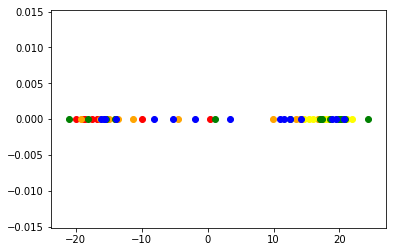

In [9]:
pca = CodaPCA.CodaPCA(1,lrate=1e-3,nn_shape=[100,100], alg=CodaPCA.Alg.CODAPCA)
pca.fit(bee_features)
test = pca.transform(bee_features)


y = np.zeros(len(test[apiary_a]))
plt.scatter(test[apiary_a], y = np.zeros(len(test[apiary_a])), c ="red")
plt.scatter(test[apiary_b], y = np.zeros(len(test[apiary_b])),c ="orange")
plt.scatter(test[apiary_c],  y = np.zeros(len(test[apiary_c])),c ="yellow")
plt.scatter(test[apiary_d],  y = np.zeros(len(test[apiary_d])),c ="green")
plt.scatter(test[apiary_e], y = np.zeros(len(test[apiary_e])), c ="blue")

plt.show()



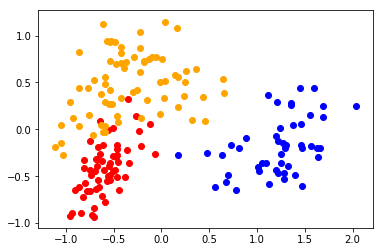

In [50]:
wine = pd.read_csv("wine.data", header=None)
wine_1 = np.where(wine[0] == 1)
wine_2 = np.where(wine[0] == 2)
wine_3 = np.where(wine[0] == 3)


# adult = data_9.to_numpy()[adult_inds]
# child = data_9.to_numpy()[child_inds]
features = wine[wine.columns[1:]].to_numpy()

features = np.array([feat/sum(feat) for feat in features])



# # pca_clr = CodaPCA.CLRPCA(2)
# # pca_clr.fit(features)
# # test = pca_clr.transform(features)

# pca = CodaPCA.CodaPCA(2,lrate=1e-3,nn_shape=[100,100], alg=CodaPCA.Alg.CODAPCA)
# pca.fit(features)
# test = pca.transform(features)


pca_clr = CodaPCA.CLRPCA(2)
pca_clr.fit(features)
test = pca_clr.transform(features)

plt.scatter(x = test[wine_1][:,0], y = test[wine_1][:,1], c ="red")
plt.scatter(x = test[wine_2][:,0], y = test[wine_2][:,1], c ="orange")
plt.scatter(x = test[wine_3][:,0], y = test[wine_3][:,1], c ="blue")


plt.show()





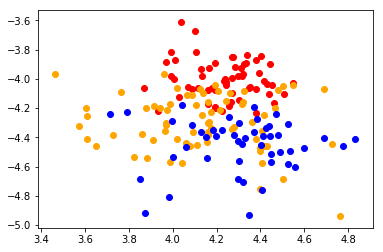

In [36]:
from sklearn.decomposition import PCA
naive_pca = PCA(2)
naive_pca.fit(features)
test = pca.transform(features)

plt.scatter(x = test[wine_1][:,0], y = test[wine_1][:,1], c ="red")
plt.scatter(x = test[wine_2][:,0], y = test[wine_2][:,1], c ="orange")
plt.scatter(x = test[wine_3][:,0], y = test[wine_3][:,1], c ="blue")


plt.show()



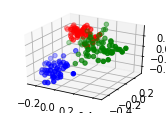

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(222, projection='3d')



# pca = CodaPCA.CodaPCA(3,lrate=1e-3,nn_shape=[100,100], alg=CodaPCA.Alg.CODAPCA)
# pca.fit(features)
# test = pca.transform(features)

pca = CodaPCA.NonParametricCodaPCA(3)
pca.fit(features)
test = pca.transform(features)


# pca_clr = CodaPCA.CLRPCA(3)
# pca_clr.fit(features)
# test = pca_clr.transform(features)


# naive_pca = PCA(2)
# naive_pca.fit(features)
# test = pca.transform(features)



ax.scatter(xs = test[wine_1][:,0], ys = test[wine_1][:,1],zs = test[wine_1][:,1], c ="red")
ax.scatter(xs= test[wine_2][:,0], ys = test[wine_2][:,1],zs = test[wine_2][:,1], c ="green")
ax.scatter(xs = test[wine_3][:,0], ys = test[wine_3][:,1],zs = test[wine_3][:,1], c ="blue")
